In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
#hide
!pip install -Uqq fastbook
#! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastbook import *
from fastai.vision.widgets import *

In [10]:
#bing image search does not work even using Azure key, follow below to use this code instead
#https://forums.fast.ai/t/lesson-2-question-on-how-to-get-a-bing-image-search-api-key/96166/5
from fastbook import *
urls = search_images_ddg('grizzly bear', max_images=100) #150
len(urls),urls[0]

(100,
 'http://4.bp.blogspot.com/-3WcCGQ1bzJI/UXcshw5QEwI/AAAAAAAAIns/gfJpUVE0FK8/s1600/Grizzly-Bear-7.jpg')

In [8]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

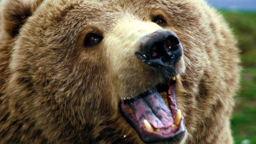

In [11]:
download_url(urls[7], 'images/bear.jpg')
im = Image.open('images/bear.jpg')
im.thumbnail((256,256))
im

In [12]:
#download images
for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images_ddg(f'{o} bear'))
    resize_images(path/o, max_size=400, dest=path/o)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [13]:
fns = get_image_files(path)
fns

(#564) [Path('bears/grizzly/f8de1d8f-e7a8-4591-ace1-6125928bb193.jpg'),Path('bears/grizzly/6ef8b4da-310f-4c48-82e2-78825e1abe29.jpg'),Path('bears/grizzly/24e7158c-6373-4bec-84e7-79fc6d21451d.jpg'),Path('bears/grizzly/4682510f-2656-4118-94e5-81d1f69f4593.jpg'),Path('bears/grizzly/862f2635-8a9c-4028-9f1f-2307d1c1b5d7.jpg'),Path('bears/grizzly/aa857650-b48a-4b52-8618-5b5c7325d96b.jpg'),Path('bears/grizzly/b7656737-de3d-480e-9fdf-5b9d3b210138.jpg'),Path('bears/grizzly/8fe74e7d-f166-49aa-9202-85ed377eb4b7.jpg'),Path('bears/grizzly/e126f0ef-b8a7-4416-83ff-3e749d1993d2.jpg'),Path('bears/grizzly/fafd6c6f-08e8-4eee-99f0-3efbd2534df9.jpg')...]

In [14]:
failed = verify_images(fns)
failed

(#21) [Path('bears/grizzly/9e6ed4e2-7460-42db-8a44-18ef7dd123f0.jpg'),Path('bears/grizzly/5db98f0d-21e6-43e0-8a0f-1527b1ce0e7c.jpg'),Path('bears/teddy/e03de873-4b42-4583-a769-0dfc447a31e9.jpg'),Path('bears/teddy/e0569233-3d2b-408f-8c88-69be95e2a857.jpg'),Path('bears/teddy/ee4e564c-f400-40ec-b460-f904c9c6c04d.jpg'),Path('bears/teddy/2db9350c-8b8a-4c4f-953b-37bad45ffb88.jpg'),Path('bears/teddy/515ce536-25dc-4c2a-a4c0-2c7ea581aa2d.jpg'),Path('bears/teddy/bf16df4c-72f8-4d04-9e6a-5adcb1b347ab.jpg'),Path('bears/teddy/d9f2bb83-63a1-428b-92ff-dc911e7b4075.jpg'),Path('bears/teddy/f84e34ad-25be-4ce2-b31c-cf2c41f5b0ba.jpg')...]

In [15]:
#To remove all the failed images, you can use unlink on each of them
failed.map(Path.unlink);

In [16]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = bears.dataloaders(path)

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a mini-batch). To group them in a big array (usually called a tensor) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. Item transforms are pieces of code that run on each individual item, whether it be an image, category, or so forth. fastai includes many predefined transforms; we use the Resize transform here:

item_tfms=Resize(128)

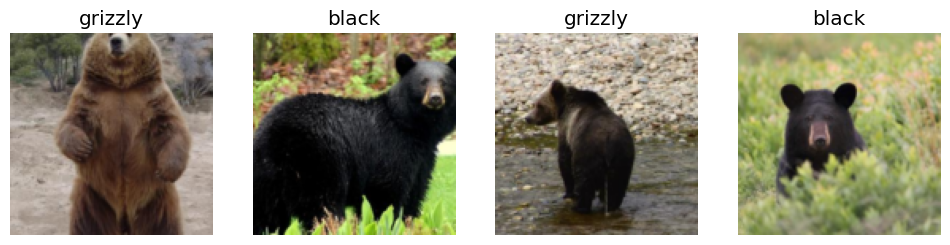

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

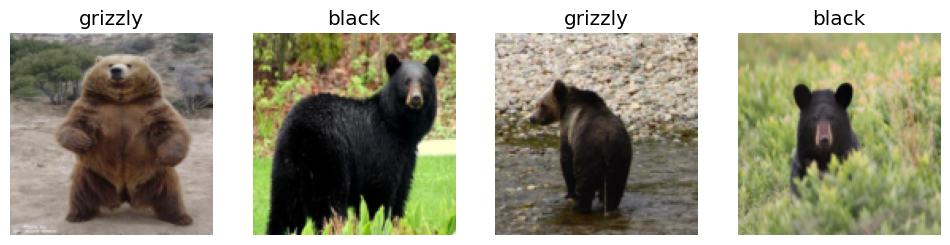

In [18]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

#bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
#dls = bears.dataloaders(path)
#dls.valid.show_batch(max_n=4, nrows=1)

what we normally do in practice is to randomly select part of the image, and crop to just that part. On each epoch (which is one complete pass through all of our images in the dataset) we randomly select a different part of each image. This means that our model can learn to focus on, and recognize, different features in our images. It also reflects how images work in the real world: different photos of the same thing may be framed in slightly different ways.

In fact, an entirely untrained neural network knows nothing whatsoever about how images behave. It doesn't even recognize that when an object is rotated by one degree, it still is a picture of the same thing! So actually training the neural network with examples of images where the objects are in slightly different places and slightly different sizes helps it to understand the basic concept of what an object is, and how it can be represented in an image.

Here's another example where we replace Resize with RandomResizedCrop, which is the transform that provides the behavior we just described. The most important parameter to pass in is min_scale, which determines how much of the image to select at minimum each time:

We used unique=True to have the same image repeated with different versions of this RandomResizedCrop transform. 

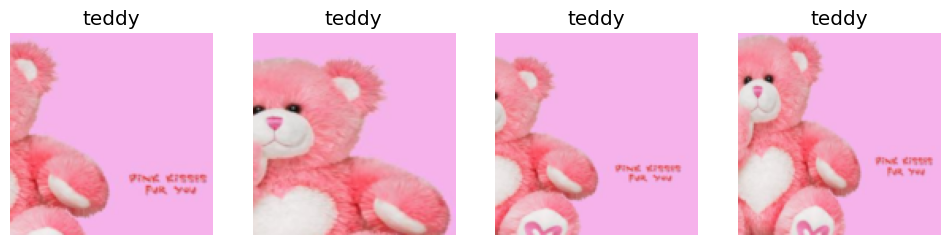

In [20]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

Data augmentation refers to creating random variations of our input data, such that they appear different, but do not actually change the meaning of the data. Examples of common data augmentation techniques for images are rotation, flipping, perspective warping, brightness changes and contrast changes. For natural photo images such as the ones we are using here, a standard set of augmentations that we have found work pretty well are provided with the aug_transforms function. Because our images are now all the same size, we can apply these augmentations to an entire batch of them using the GPU, which will save a lot of time. To tell fastai we want to use these transforms on a batch, we use the batch_tfms parameter (note that we're not using RandomResizedCrop in this example, so you can see the differences more clearly; we're also using double the amount of augmentation compared to the default, for the same reason):

mult:float=1.0, # Multiplication applying to `max_rotate`,`max_lighting`,`max_warp`

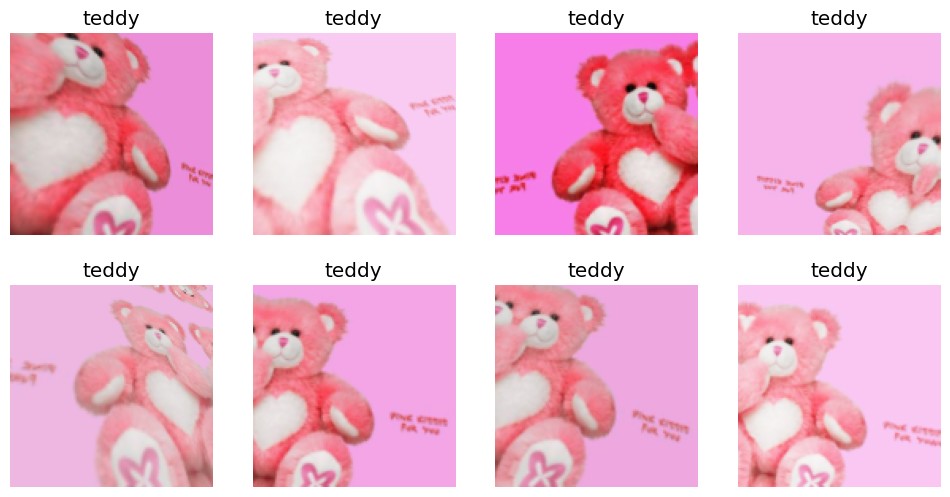

In [19]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [23]:
?? aug_transforms

Signature:
 aug_transforms(
    mult: 'float' = 1.0,
    do_flip: 'bool' = True,
    flip_vert: 'bool' = False,
    max_rotate: 'float' = 10.0,
    min_zoom: 'float' = 1.0,
    max_zoom: 'float' = 1.1,
    max_lighting: 'float' = 0.2,
    max_warp: 'float' = 0.2,
    p_affine: 'float' = 0.75,
    p_lighting: 'float' = 0.75,
    xtra_tfms: 'list' = None,
    size: 'int | tuple' = None,
    mode: 'str' = 'bilinear',
    pad_mode='reflection',
    align_corners=True,
    batch=False,
    min_scale=1.0,
)
Source:   
def aug_transforms(
    mult:float=1.0, # Multiplication applying to `max_rotate`,`max_lighting`,`max_warp`
    do_flip:bool=True, # Random flipping
    flip_vert:bool=False, # Flip vertically
    max_rotate:float=10., # Maximum degree of rotation
    min_zoom:float=1., # Minimum zoom 
    max_zoom:float=1.1, # Maximum zoom 
    max_lighting:float=0.2, # Maximum scale of changing brightness 
    max_warp:float=0.2, # Maximum value of changing warp per
    p_affine:float=0.75, #

In [24]:
#complete randomResized Crop and  augmented transformation before training the model
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [25]:
#train the model
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 129MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.324947,0.100685,0.046296,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.224952,0.041391,0.027778,00:02
1,0.200273,0.053966,0.027778,00:02
2,0.147166,0.066601,0.027778,00:02
3,0.122070,0.068914,0.037037,00:02


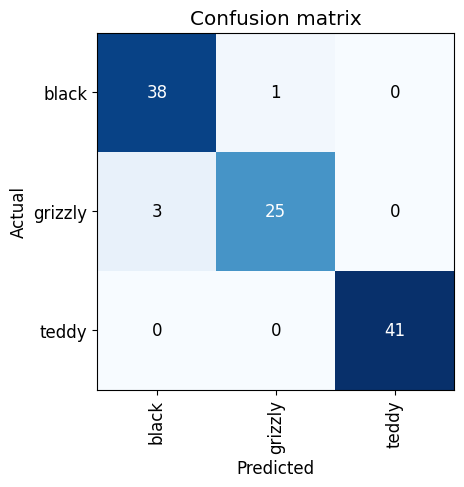

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

plot_top_losses shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction:

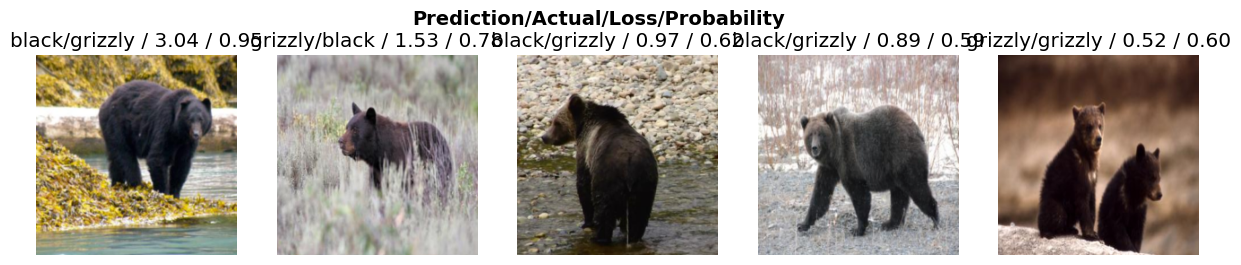

In [27]:
interp.plot_top_losses(5, nrows=1)

fastai includes a handy GUI for data cleaning called ImageClassifierCleaner that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling:

In [ ]:
#ImageClassifierCleaner has issue, do not run
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [29]:
learn.export()

In [30]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [31]:
learn_inf = load_learner(path/'export.pkl')

In [33]:
learn_inf.predict('images/bear.jpg')

('grizzly', tensor(1), tensor([1.1321e-04, 9.9946e-01, 4.2849e-04]))

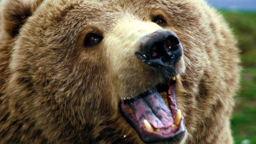

In [34]:
im = Image.open('images/bear.jpg')
im.thumbnail((256,256))
im

This has returned three things: the predicted category in the same format you originally provided (in this case that's a string), the index of the predicted category, and the probabilities of each category. The last two are based on the order of categories in the vocab of the DataLoaders; that is, the stored list of all possible categories. At inference time, you can access the DataLoaders as an attribute of the Learner:

In [35]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [38]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [43]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/bear.jpg'])

In [45]:
img = PILImage.create(btn_upload.data[-1])

In [46]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [47]:
pred,pred_idx,probs = learn_inf.predict(img)

In [48]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9995')

In [49]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [50]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [51]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [52]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [53]:
%pwd

'/kaggle/working'

UsageError: Line magic function `%zip` not found.


In [60]:
# zip all files from /kaggle/working directory then downloand
#run below in console
# !zip -r file.zip /kaggle/working
# then run below code use IPython to download file by specify the file name
from IPython.display import FileLink
FileLink(r'file.zip')

/kaggle/working/file.zip